In [186]:
from collections import Counter
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import seaborn as sns
import matplotlib.pyplot as plt


In [187]:
cloud_config= {
  'secure_connect_bundle': 'path_to_your_secure_connect_mydb.zip/secure-connect-mydb.zip'
}
auth_provider = PlainTextAuthProvider('<<clientId>>', '<<clientSecret>>')
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect("<<namespace>>")


In [188]:
import pandas as pd
from datetime import datetime
df = pd.read_csv('your_csv_file.csv',nrows=15500,parse_dates=['pickup_datetime','dropoff_datetime'],infer_datetime_format=True, encoding='ISO 8859-1') 
df2=pd.read_csv('your_csv_file_2.csv',nrows=15500,encoding='ISO 8859-1') 

In [189]:
df=df.drop(columns=['store_and_fwd_flag'])
df=df.drop(columns=['rate_code'])
df=df.drop(columns=['total_amount'])

In [190]:
df = df.dropna(subset=['fare_amount', 'extra','mta_tax','tip_amount','tolls_amount','imp_surcharge','passenger_count','payment_type','pickup_location_id'])
df['total']=df['fare_amount']+df['extra']+df['mta_tax']+df['tip_amount']+df['tolls_amount']+df['imp_surcharge']

In [191]:
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()
#lamda works  as  function that loops around the rows and checks the hour and filters accordingly
df['trip_time'] = df['pickup_datetime'].apply(lambda x: 'Night' if x.hour < 6 else ('Morning' if x.hour < 12 else ('Afternoon' if x.hour < 18 else 'Evening')))

In [192]:
# session.execute("""
#     create table if not exists taxi.taxidata (
#         vendor_id text,
#         pickup_datetime timestamp,
#         dropoff_datetime timestamp,
#         passenger_count int,
#         trip_distance float,
#         payment_type int,
#         fare_amount float,
#         extra float,
#         mta_tax float,
#         tip_amount float,
#         tolls_amount float,
#         imp_surcharge float,
#         pickup_location_id text,
#         dropoff_location_id text,
#         trip_duration float,
#         total float,
#         zone_id int,
#         trip_time text,
#         Primary Key (passenger_count,pickup_location_id)
#     );
# """)

In [193]:
# for x in range(0, 10000):
#     session.execute("""
#         insert into taxi.taxidata (
#             vendor_id,
#             pickup_datetime,
#             dropoff_datetime,
#             passenger_count,
#             trip_distance,
#             payment_type,
#             fare_amount,
#             extra,
#             mta_tax,
#             tip_amount,
#             tolls_amount,
#             imp_surcharge,
#             pickup_location_id,
#             dropoff_location_id,
#             trip_duration,
#             total,
#             trip_time
#         ) values (
#             '%s',
#             '%s',
#             '%s',
#             %d,
#             %f,
#             %d,
#             %f,
#             %f,
#             %f,
#             %f,
#             %f,
#             %f,
#             '%s',
#             '%s',
#             %f,
#             %f,
#             '%s'
#         );
#     """ % (
#         df.loc[x].vendor_id,
#         df.loc[x].pickup_datetime,
#         df.loc[x].dropoff_datetime,
#         int(df.loc[x].passenger_count),
#         float(df.loc[x].trip_distance),
#         int(df.loc[x].payment_type),
#         float(df.loc[x].fare_amount),
#         float(df.loc[x].extra),
#         float(df.loc[x].mta_tax),
#         float(df.loc[x].tip_amount),
#         float(df.loc[x].tolls_amount),
#         float(df.loc[x].imp_surcharge),
#         df.loc[x].pickup_location_id,
#         df.loc[x].dropoff_location_id,
#         float(df.loc[x].trip_duration),
#         float(df.loc[x].total),
#         str(df.loc[x].trip_time)
#     ))



In [194]:
 
# session.execute("drop table if exists taxi.taxidata")


# to get the  most common payment type used per time of day


In [195]:


morning_payment=session.execute("Select payment_type from taxi.taxidata where trip_time='Morning' ALLOW FILTERING")

afternoon_payment=session.execute("Select payment_type from taxi.taxidata where trip_time='Afternoon' ALLOW FILTERING")

evening_payment=session.execute("Select payment_type from taxi.taxidata where trip_time='Evening' ALLOW FILTERING")

night_payment=session.execute("Select payment_type from taxi.taxidata where trip_time='Night' ALLOW FILTERING")



In [196]:
morning_count = Counter([row.payment_type for row in morning_payment])
afternoon_count = Counter([row.payment_type for row in afternoon_payment])
evening_count = Counter([row.payment_type for row in evening_payment])
night_count = Counter([row.payment_type for row in night_payment])

print("At morning", morning_count.most_common(1)[0])
print("At afternoon", afternoon_count.most_common(1)[0])
print("At evening", evening_count.most_common(1)[0])
print("At night", night_count.most_common(1)[0])

At morning (1, 87)
At afternoon (1, 94)
At evening (1, 102)
At night (1, 35)


# to get the avg tip amount per passenger count


In [197]:
for i in range(1,7):
 avg=session.execute('select avg(tip_amount) from taxi.taxidata group by passenger_count')
 print("passenger_count",i ,avg[0])

passenger_count 1 Row(system_avg_tip_amount=2.0587692260742188)
passenger_count 2 Row(system_avg_tip_amount=2.0587692260742188)


/var/folders/fj/l_r4z3yn7sx4k3ppwd_khgwr0000gn/T/ipykernel_42770/2477566128.py:3: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  print("passenger_count",i ,avg[0])


passenger_count 3 Row(system_avg_tip_amount=2.0587692260742188)
passenger_count 4 Row(system_avg_tip_amount=2.0587692260742188)
passenger_count 5 Row(system_avg_tip_amount=2.0587692260742188)
passenger_count 6 Row(system_avg_tip_amount=2.0587692260742188)


In [198]:
# for i in range(1,7):
#    avg=session.execute('select avg(tip_amount) from taxi.taxidata group by passenger_count ')
#    print("passenger_count",i ,avg[0])
for i in range(1,7):
    avgs=session.execute("SELECT AVG(tip_amount) as average FROM taxi.taxidata WHERE passenger_count= %s  ALLOW FILTERING" % i)
    print("passenger_count",i ,avgs[0])

passenger_count 1 Row(average=1.613025188446045)
passenger_count 2 Row(average=1.5259301662445068)


/var/folders/fj/l_r4z3yn7sx4k3ppwd_khgwr0000gn/T/ipykernel_42770/3984167248.py:6: DeprecationWarning: ResultSet indexing support will be removed in 4.0. Consider using ResultSet.one() to get a single row.
  print("passenger_count",i ,avgs[0])


passenger_count 3 Row(average=1.7795082330703735)
passenger_count 4 Row(average=3.4666666984558105)
passenger_count 5 Row(average=2.0587692260742188)
passenger_count 6 Row(average=1.9810526371002197)


# the best 5 locations for drivers to pick up passengers from (best == frequent)


In [199]:
x=session.execute("SELECT pickup_location_id FROM taxi.taxidata")
pickup_locations = [row[0] for row in x]
top_locations = Counter(pickup_locations).most_common(5)
print(top_locations)
zones=df2.query("zone_id==100 | zone_id==107 | zone_id==113 | zone_id==114 | zone_id==13")["zone_name"]
print(zones)


[('100', 7), ('107', 7), ('113', 7), ('114', 7), ('13', 7)]
176          Battery Park City
191           Garment District
195                   Gramercy
196    Greenwich Village North
197    Greenwich Village South
Name: zone_name, dtype: object


In [200]:
#-------NOT WORKING-------

session.execute("SELECT pickup_location_id, count(*) as lcount FROM taxi.taxidata ORDER BY lcount DESC LIMIT 5  ALLOW FILTERING ;")

InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name lcount"

# BONUS

0.0 84.38
-1.56 80.08


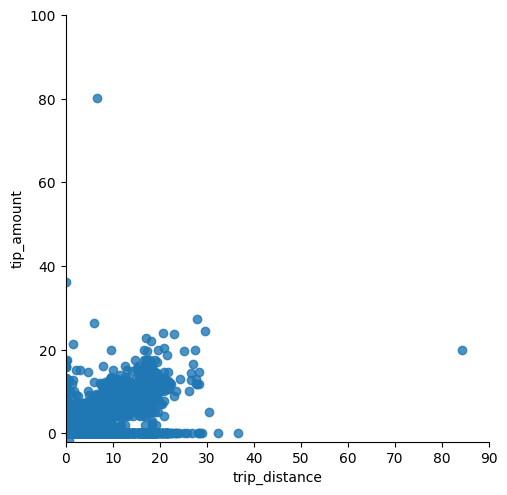

In [206]:
print(min(df["trip_distance"]),max(df["trip_distance"]))
print(min(df["tip_amount"]),max(df["tip_amount"]))

sns.lmplot( x="trip_distance", y="tip_amount", data=df, fit_reg=False)
 
# control x and y limits
plt.ylim(-2, 100)
plt.xlim(0, 90)
 
plt.show()

to better understand the correlation between trip_distance and tip_amount,we plotted a scatter plot
as we can see there is a positive correlation between both variables which means the longer the trip, the more tip is paid